Load and inspect data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset - CSV is in data/ directory (one level up from notebooks/)
df = pd.read_csv('../data/togo-dapaong_qc.csv')
print(f"✓ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()
df.info()

✓ Dataset loaded: 525600 rows × 19 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null 

Summary statistics & missing values

In [3]:
df.describe(include='all')
df.isna().sum()

# Find columns with >5% missing
missing = df.isna().sum() / len(df) * 100
missing_cols = missing[missing > 5]
print(missing_cols)

Comments    100.0
dtype: float64


Outlier Detection (Z-Score Method)


In [4]:
from scipy import stats

numeric_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy='omit'))

outliers = (z_scores > 3)
df_outliers = df[outliers.any(axis=1)]
print("Outliers detected:", len(df_outliers))

Outliers detected: 9251


Then decide to drop or impute:

In [5]:
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))
df = df[(z_scores < 3).all(axis=1)]


Save the cleaned dataset


In [6]:
df.to_csv("../data/togo_clean.csv", index=False)


Time Series Analysis

Plot irradiance and temperature vs time:

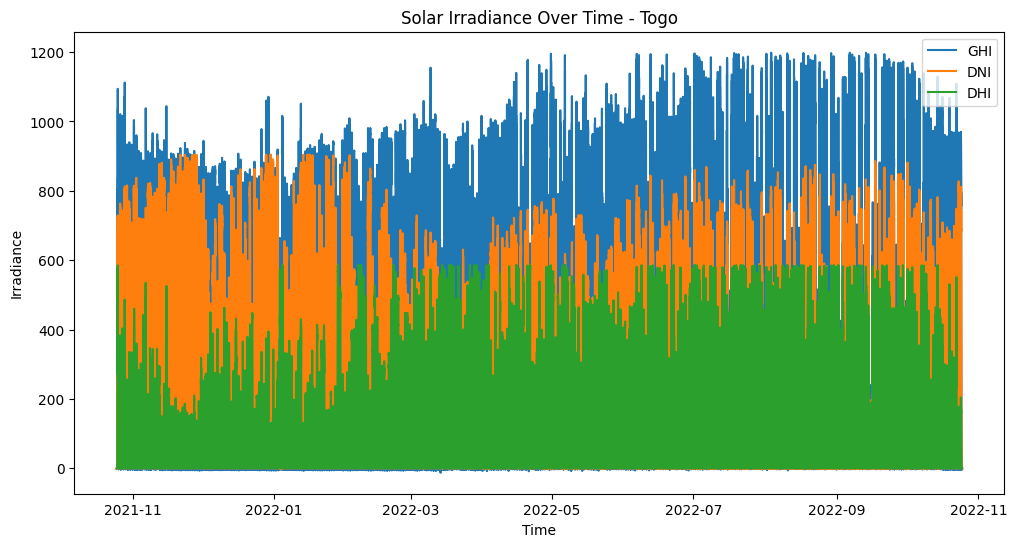

In [7]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

plt.figure(figsize=(12,6))
plt.plot(df["Timestamp"], df["GHI"], label="GHI")
plt.plot(df["Timestamp"], df["DNI"], label="DNI")
plt.plot(df["Timestamp"], df["DHI"], label="DHI")
plt.xlabel("Time")
plt.ylabel("Irradiance")
plt.title("Solar Irradiance Over Time - Togo")
plt.legend(loc="upper right")
plt.show()

Cleaning Impact

Text(0.5, 1.0, 'Impact of Cleaning on Module Performance')

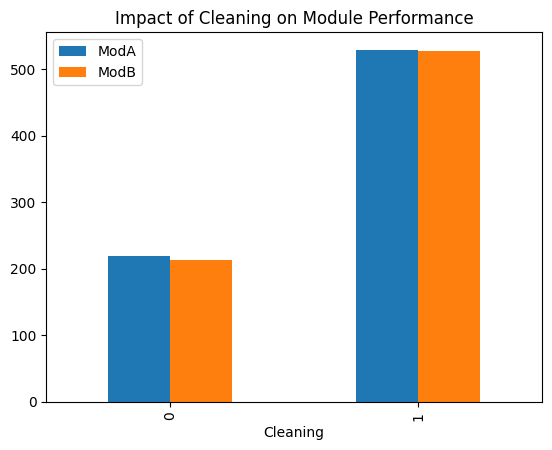

In [8]:
df.groupby("Cleaning")[["ModA", "ModB"]].mean().plot(kind="bar")
plt.title("Impact of Cleaning on Module Performance")


Correlation & Relationships

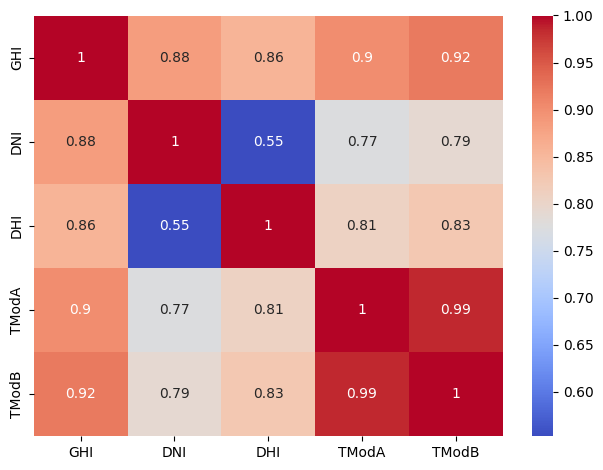

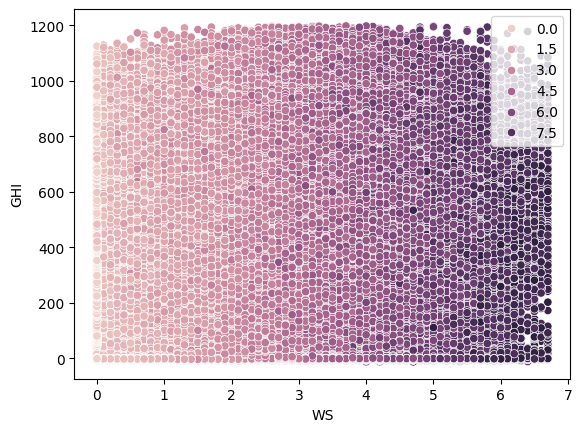

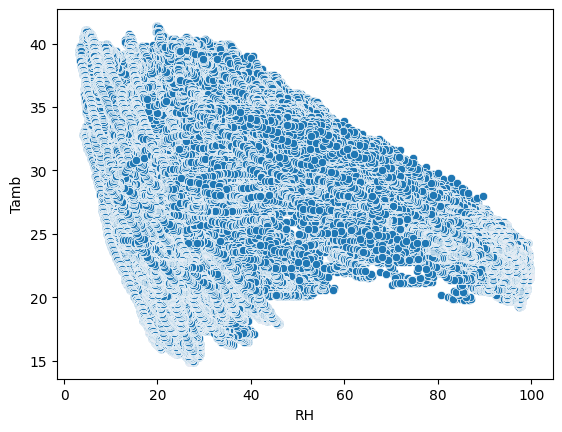

In [9]:
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

plt.figure()
ax = sns.scatterplot(data=df, x="WS", y="GHI", hue="WSgust")
ax.legend(loc="upper right")
plt.show()

plt.figure()
sns.scatterplot(data=df, x="RH", y="Tamb")
plt.show()

Wind & Distribution Analysis


<Axes: xlabel='GHI', ylabel='Count'>

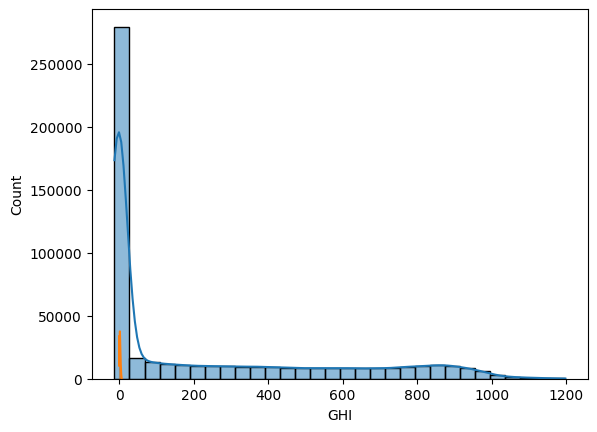

In [11]:
sns.histplot(df["GHI"], bins=30, kde=True)
sns.histplot(df["WS"], bins=30, kde=True)


Wind rose (optional)

Text(0.5, 1.0, 'Wind Rose - Benin')

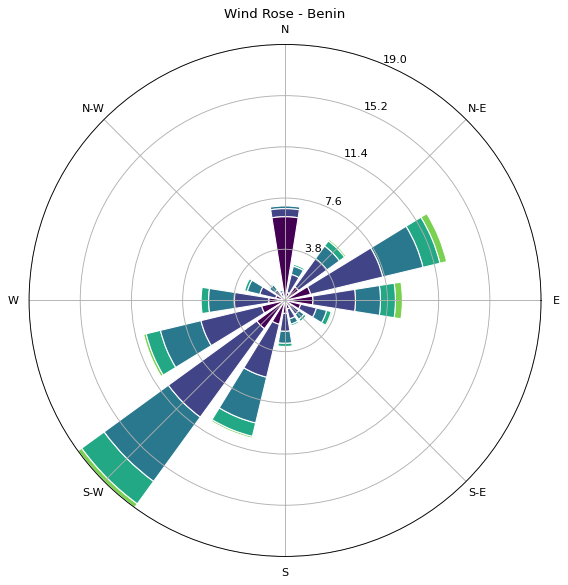

In [12]:
import windrose
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(df["WD"], df["WS"], normed=True, opening=0.8, edgecolor='white')
ax.set_title("Wind Rose - Benin")

Temperature & Humidity Relationship

Text(0.5, 1.0, 'Relationship between RH, Temperature, and GHI')

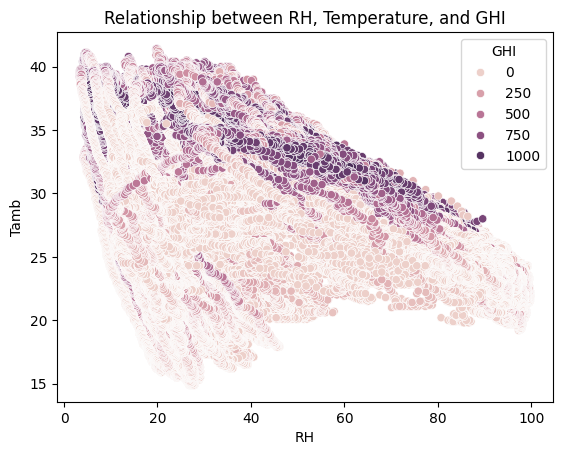

In [13]:
sns.scatterplot(data=df, x="RH", y="Tamb", hue="GHI")
plt.title("Relationship between RH, Temperature, and GHI")



Bubble Chart (for visual insight)


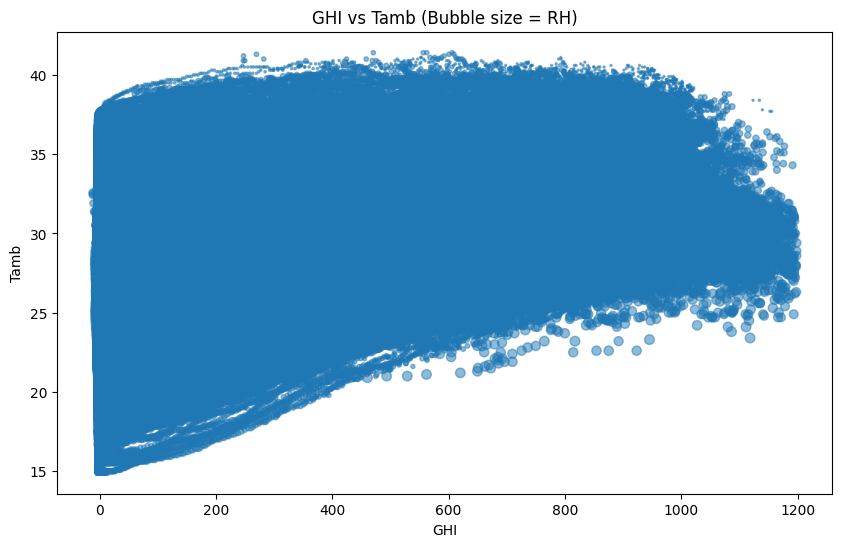

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(df["GHI"], df["Tamb"], s=df["RH"]/2, alpha=0.5)
plt.xlabel("GHI")
plt.ylabel("Tamb")
plt.title("GHI vs Tamb (Bubble size = RH)")
plt.show()